# Matching

We developed one crawler to get data from https://www.submarino.com.br/categoria/celulares-e-smartphones/smartphone. This crawler are responsible to get some smartphone from this e-commerce.

We get a total of 6676 smartphones (this value is the total smartphone available in submarino's website until the time of execution of this project, ie all smartphones were stored from the link above)

Now we want to compare these data with another dataset (from other e-commerce) that have some smartphones. Our goal is verify what smartphone are equal in both dataset.

# 1. Exploring dataset

In [1]:
# Imports

# Data manipulation
import numpy as np
import pandas as pd

# Text manipulation
from unidecode import unidecode
import string
import nltk

# ML
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

# Compare strings
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Parse html
import requests
from lxml import html

In [2]:
# Read data and filter by just smartphone values
other_smart = pd.read_csv('smart_or_not.csv')
other_smart = other_smart[other_smart['target'] == 1]
other_smart = other_smart.drop(columns=['target'])

# Read data
submarino_smart = pd.read_csv('crawler_submarino/data.csv')

In [3]:
# Some data
other_smart.head()

,title
0,alcatel a3 xl max dourado 32gb 3gb ram quad-core
1,alcatel one touch pop c7 branco tela 5 '' dua...
2,apple iphone 5c 16gb original apple
3,"apple iphone 8 plus 64gb tela 5,5"
4,asus zenfone 2 ze551ml 4g android 5.0 intel q...


In [4]:
# Some data
submarino_smart.head()

,title
0,Smartphone Motorola One Vision 128GB Dual Chip...
1,"Iphone 8 Plus 64GB Ouro Tela 5.5"" iOS 12 4G C..."
2,iPhone 8 Plus 64gb Silver Tela 5.5” iOS 12 4G ...
3,Smartphone Samsung Galaxy S10e 128GB Dual Chip...
4,Smartphone Samsung Galaxy Note 9 128GB Nano Ch...


In [5]:
# Number of samples of each dataset
print('Other',other_smart.shape[0])
print('Submarino',submarino_smart.shape[0])

Other 519
Submarino 6676


The first thing we need to care about it's that we have more smartphones in submarino than 'other' dataset. So we can just match a total of 519 smartphones.

Before we match our both dataset's let's cleaning submarino's data.

# 2. Data Cleaning

Cleaning dataset submarino.

In [6]:
# Portuguese stopwords
stopwords = nltk.corpus.stopwords.words('portuguese')

# Stemming in portuguese
stemmer = nltk.stem.RSLPStemmer()

'''

Cleaning text.

'''
def text_clean(doc,stemmer=False):
    
    # Creating tokens and remove accentuation
    token = nltk.word_tokenize(unidecode(doc.lower()),language='portuguese')
    
    # Stemming
    if(stemmer):
        token = [stemmer.stem(word) for word in token]
    
    # Remove stopwords
    token =  [word for word in token if word not in stopwords]  
    
    # Remove punctuation
    token = [word for word in token if word not in string.punctuation]
    
    return ' '.join(token)

In [7]:
# Clean text
submarino_smart['title'] = submarino_smart['title'].map(text_clean)

We have an a priori knowledge that some words are associated with smartphone, so the sentence itself does not refer to the electronic device itself.

So, even if our data were collected only from the smartphone category, it is important to check that there is no 'dirt' on the headset.

In [8]:
'''

Check if each word in a list appear in sentence.

Parameters:
-----------
x: Sentence.
word: List of words to check

Returns:
-----------
True ou False indicanting if exist or not these words.

'''
def check_smart(x,word):
    if (len([True for w in word if ' '+ w +' ' in ' '+ x +' '])>0):
        return True
    else:
        return False

In [9]:
# Creating a word list - same words computed in notebook Smartphone-Detection
word_list = ['capa','pelicula','transparente','pc','bumper','protetora','cover','vidro']

In [10]:
# Check some words
submarino_smart[submarino_smart['title'].map(lambda x: check_smart(x,word_list))].head(20)

,title
240,smartphone asus zenfone 4 dual chip android no...
382,capa case hmaston moto g7
408,smartphone zte blade l5 dual chip android tela...
414,smartphone multilaser ms45 colors preto p9009 ...
437,smartphone asus zenfone zoom s dual chip andro...
539,smartphone asus zenfone 4 dual chip android no...
577,smartphone asus zenfone zoom s dual chip andro...
660,smartphone asus zenfone 4 64gb dual chip andro...
699,smartphone asus zenfone 4 dual chip android no...
760,capa iphone 6s plus silicone case ch gray-bra-...


Notice that we have somes sentences with keyword 'smartphone' but they are considered to have some word from our word list. Let's check these sentences.

In [11]:
submarino_smart['title'].loc[240]

"smartphone asus zenfone 4 dual chip android nougat 7.0 tela 5.5 '' qualcomm snapdragon 64gb 4g camera 12 8mp dual traseira wide angle 120deg capa verde"

In [12]:
submarino_smart['title'].loc[414]

"smartphone multilaser ms45 colors preto p9009 camera 5mp tela 4.5 '' 1 capa extra microsd 8gb"

So these sentences refers to a smartphone but they also have one 'capa', ie, both are selling together.

To solve this, let's apply our word list just in words that don't have 'smartphone'.

In [13]:
# Show sentences
submarino_smart[submarino_smart['title'].map(lambda x: False if 'smartphone' in x else check_smart(x,word_list))]

,title
382,capa case hmaston moto g7
760,capa iphone 6s plus silicone case ch gray-bra-...
766,capa asus zenfone 3 max zc520tl tela 5.2 pixels
770,capa asus zenfone 3 max zc520tl tela 5.2 pixels
1016,capa motorola moto g circulos
1051,pelicula vidro lente camera principal traseira...
1058,capa celular prova dagua multilaser original
1076,capa silicone tpu tablet samsung tab a6 7 sm- ...
1115,capa brilhosa pop socket lg k11
1139,capa celular prova dagua multilaser original


Our check appears to be right now, so we will delete these rows.

In [14]:
# Filter
submarino_smart = submarino_smart[~submarino_smart['title'].map(lambda x: False if 'smartphone' in x else check_smart(x,word_list))]

Now our next step it's remove some words that can disturb our matching:

- smartphone.
- colors: We will consider that smartphones with different colors will be treated equally.

We will get a list o colors in english and portuguese from wikipedia. They will be used to remove in sentences.

In [15]:
'''

Get colors in english and portuguese

Return:
-----------
List of colors

'''
def get_colors():

    # ENGLISH

    # Request
    req = requests.get('https://simple.wikipedia.org/wiki/List_of_colors')

    # Parse request to a doc
    doc = html.fromstring(req.content)

    # Get element in html
    colors =  doc.xpath('//*[@id="mw-content-text"]/div/table[1]/tbody/tr')

    # Store all colors in a list
    colors_list = []
    for c in colors[1:]:
        colors_list.append(c.xpath('td[1]/a/text()')[0])

    # PORTUGUESE

    # Request
    req = requests.get('https://pt.wikipedia.org/wiki/Lista_de_cores')

    # Parse request to a doc
    doc = html.fromstring(req.content)

    # Get all leters
    all_letters = doc.find_class('wikitable')

    # Store all colors in a list
    for letter in all_letters:
        table = letter.xpath('tbody/tr')

        for t in table[1:]:
            colors_list.append(t.xpath('th')[0].text_content().replace('\n',''))

    return [unidecode(c.lower()) for c in colors_list]

In [16]:
# List of colors
colors_list = get_colors()

In [17]:
# Add word smartphone in color list to remove too
colors_list = colors_list + ['smartphone']

In [18]:
'''

Replace words in sentences given a list.

Parameters:
-----------
x: Sentence.
word: List of words to remove in sentence.

Returns:
-----------


'''
def replace_words(x,word):
    
    # Replace words
    for w in word:
        if(w in x):
            x = x.replace(w,'')
            
    # Remove multiple spaces
    x = " ".join(x.split())
    
    return x

In [19]:
# Remove words from color_list in dataset
submarino_smart['title'] = submarino_smart['title'].map(lambda x: replace_words(x,colors_list))
other_smart['title'] = other_smart['title'].map(lambda x: replace_words(x,colors_list))

#  3. Text Analysis

Now that we have a cleaned dataset let's analyze it.

In [20]:
'''

Perform ngram in text

Parameters:
-----------
n: Number of ngram to use.
df: Series with text to process.
top: Number of top words to return.

Returns:
-----------
Dataframe with ngram count.

'''
def ngram(n,df,top=10):

    # Unigrams
    vec = CountVectorizer(ngram_range=(n,n)).fit(df)

    # Bag of words
    bag_of_words = vec.transform(df)

    # Sum each count
    sum_words = bag_of_words.sum(axis=0)

    # Frequency of each words
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # Sort
    words_freq.sort(key=lambda x: x[1],reverse=True)

    # Create dataframe
    words_freq = pd.DataFrame(words_freq,columns=['word','freq'])
    
    return words_freq[:top]

In [21]:
# Unigram
unigram = ngram(1,submarino_smart['title'],top=50)

In [22]:
'''

Plot ngram words.


Parameters:
-----------
x,y: Array with values to set in axis x,y.
title: Plot's title.

'''
def ngram_plot(x,y,title):
    
    # Creating figure
    fig,ax = plt.subplots(figsize=(18,7))
    sns.barplot(x=x,y=y,palette='Blues',ax=ax)

    ax.set_title(title,size=15)

    # Change xlabels/ylabels size
    ax.set_xlabel('Word',size=15)
    ax.set_ylabel('Freq',size=15)

    # Change and rotate xticklabels/yticklabels
    for tick_x in ax.get_xticklabels():
        tick_x.set_fontsize(13)
        tick_x.set_rotation(60)
    for tick_y in ax.get_yticklabels():
        tick_y.set_fontsize(13)

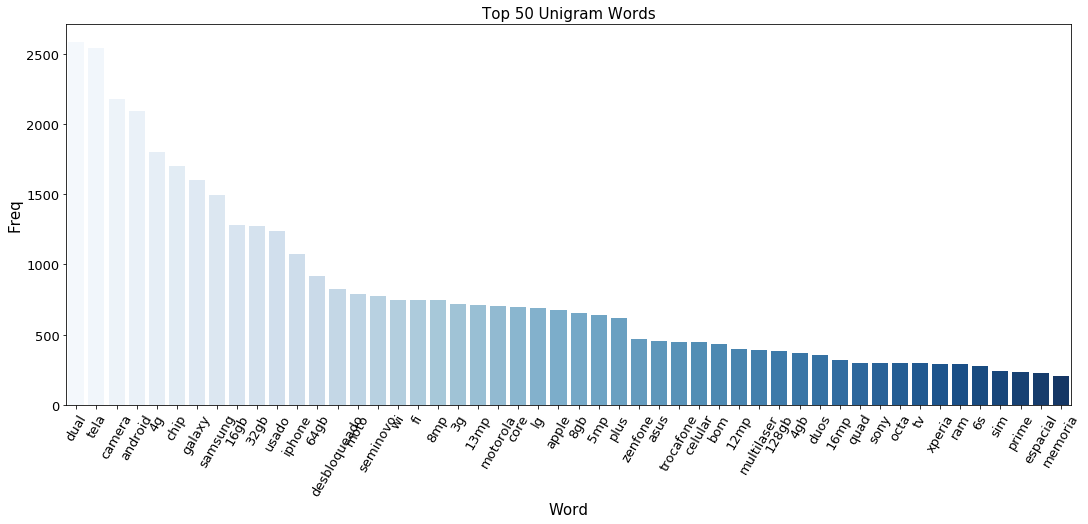

In [23]:
# Plot
ngram_plot(unigram['word'],unigram['freq'],'Top 50 Unigram Words')

In the graphic above you can see these words:

- desbloqueado
- seminovo
- trocafone
- celular
- bom
- memoria
- espacial

The first two words above indicate that we have cells used in the dataset, so in our own set there is the possibility of duplicate values. The rest of the words do not differentiate one smartphone from another and can be discarded.

We could expand this list as much as we want, and it is quite probable that we would exclude new words. But, for now, I will only use this top 50.

In [24]:
# Word list to remove
word_list = ['desbloqueado','seminovo','trocafone','celular','bom','memoria','espacial']

# Replace this words
submarino_smart['title'] = submarino_smart['title'].map(lambda x: replace_words(x,word_list))
other_smart['title'] = other_smart['title'].map(lambda x: replace_words(x,word_list))


To finish for our surprise it's possible so find some duplicate rows in submarino dataset. So we will drop them.

In [25]:
# Unique values - samples
print(len(submarino_smart['title'].unique()))

# Total - samples
submarino_smart.shape[0]

3943


6560

In [26]:
# Drop duplicates
submarino_smart = submarino_smart.drop_duplicates()

# 4. Matching

We have some techniques to compare similarity between two strings like jaccard index ou fuzzy matching. I test both methods and I don't have good results. These happens because we have a lot of words like 4g, 32gb, ram, dual, chip, etc that disturb a lot our results. These words are not so import to distinguish a smartphone from another so both techniques are not accurate.

Of course, maybe with other cleaning and preprocessing on text, maybe we have good results with jaccard ou fuzzy. So, we will not use these two techniques but we will use tf-idf.

The reason it's because this algorihtm can distinguish import words, so 4g, 32gb, ram and etc will not be so important. Therefore we will compare two matrix of tf-idf and return the row with more similarity.

In [27]:
'''

Compute similarity between two datasets. 

Parameters:
------------
array1: array used to compare by row.
array2: array used to compare.

Returns:
------------
Dataframe with similar rows.

'''
def compute_similarity(array1,array2):
    
    # Create tf-idf
    vec = TfidfVectorizer().fit(array2)

    # Transform
    tfidf_other = vec.transform(array1)
    tfidf_sub = vec.transform(array2)

    # Compute similarity between one row of tfidf_other with entire tfidf_sub
    similarity_list = []
    for index in other_smart.index.values:
        similarity_list.append(cosine_similarity(tfidf_other[index,:],tfidf_sub)[0].argmax())

    # Concat both dataset
    result = pd.DataFrame(np.concatenate((array1.reshape(-1,1),array2[similarity_list].reshape(-1,1)),axis=1))
    
    return result

In [28]:
# Compute similarity
result = compute_similarity(other_smart['title'].values,submarino_smart['title'].values)

# Save result
result.to_csv('matching.csv',index=False)